# StaTexNet - Network Encoding Statistics for Textures

## Dependencies & Hyperparameters

In [1]:
import sys
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
sys.path.append('../')  
sys.path.append('../../')  
sys.path.append('../../PooledStatisticsMetamers')
sys.path.append('../../PyTorchSteerablePyramid')
sys.path.append('../Poolstatmetamer_croppedims')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pytorch_metric_learning import losses
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

sys.path.append('../PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch
import utils.brucenet as bn
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from pytorch_lightning import seed_everything

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/state/partition1/slurm_tmp/24104601.0.0/ipykernel_3694597/934771875.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


cuda:0


In [2]:
# Seed everything with a specific seed value
seed = 10
seed_everything(seed)

Global seed set to 10


10

In [3]:
#hyperparams
batch_size = 1
crop_size = 128 
num_stats = 150
optimizer_type='adam'
#optimizer_type='sgd'
num_crops = 5 



## Create Dataset and define DataLoader

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KTHImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Filtering only directories for classes
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for sample_folder in os.listdir(class_dir):
                sample_folder_path = os.path.join(class_dir, sample_folder)
                for filename in os.listdir(sample_folder_path):
                    img_path = os.path.join(sample_folder_path, filename)
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Specify transformations
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

# Initialize dataset and dataloader
sys.path.append('/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/')

root_dir = '/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/'
dataset = KTHImageDataset(root_dir=root_dir, transform=loading_transforms)
kth_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     128,
                                     128)).to(device)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)


In [ ]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(kth_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    for i in range(texture_batch.shape[0]):
        #print(mini_batch.shape) # Loop over batch
        mini_batch = texture_batch[i]  # This should have a shape of [5, 1, 128, 128]
        mini_batch = mini_batch.to(device)

        # Now you can call brucy, which expects a tensor with shape x,1,128,128 where x > 1
        statistics = brucy(mini_batch)  # This should output a tensor of shape [5, num_stats]
        
        # You can now store these statistics, along with the label and original image index
        all_statistics.append({
            'statistics': statistics.cpu().numpy(),
            #'label': labels[i].item(),
            'original_image_index': j * texture_batch.shape[0] + i
        })



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
#print(statistics_array.shape)
labels_array = np.array([item['original_image_index'] for item in all_statistics])
# Standardize
scaler = StandardScaler()

reshaped_array = statistics_array.reshape(-1,num_stats)
#print(reshaped_array.shape)
scaled_array = scaler.fit_transform(reshaped_array)

statistics_array = scaled_array.reshape(len(dataset), 5, num_stats)
statistics_tensor = torch.tensor(statistics_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


In [ ]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [ ]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)


In [ ]:
#Create the DataLoader object first
batches = 100
statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

# Loop through a couple of batches
if(False):
    for i, (stats_batch, label_batch) in enumerate(statistics_dataloader):
        if i > 1:  # We only want to look at a couple of batches
            break

        print(f"Batch {i + 1}")

        # Dimensionality Check
        print("Statistics Batch Shape:", stats_batch.shape)  
        print("Label Batch Shape:", label_batch.shape)

        # Data Type Check
        print("Statistics Data Type:", stats_batch.dtype)
        print("Label Data Type:", label_batch.dtype)

        # Label Consistency (and value preview)
        print("Statistics:", stats_batch)
        print("Labels:", label_batch)


## Training

In [ ]:
### Try with a single layer for the original approach

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        
    def forward(self, x):
        x = self.layer1(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
)


In [13]:
from pytorch_lightning import seed_everything
import pickle

# 1. Load previously computed results if they exist
try:
    with open('feature_rankings_KTH_OT_weight.pkl', 'rb') as file:
        all_rankings_weight = pickle.load(file)
except FileNotFoundError:
    all_rankings_weight = {}

try:
    with open('feature_rankings_KTH_OT_shapley.pkl', 'rb') as file:
        all_rankings_shapley = pickle.load(file)
except FileNotFoundError:
    all_rankings_shapley = {}


In [ ]:
### Try with a single layer with dropout

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.layer1(self.dropout(x))
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
training_loss = []

num_epochs = 200
num_total_epochs = 0
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()


Starting Training:


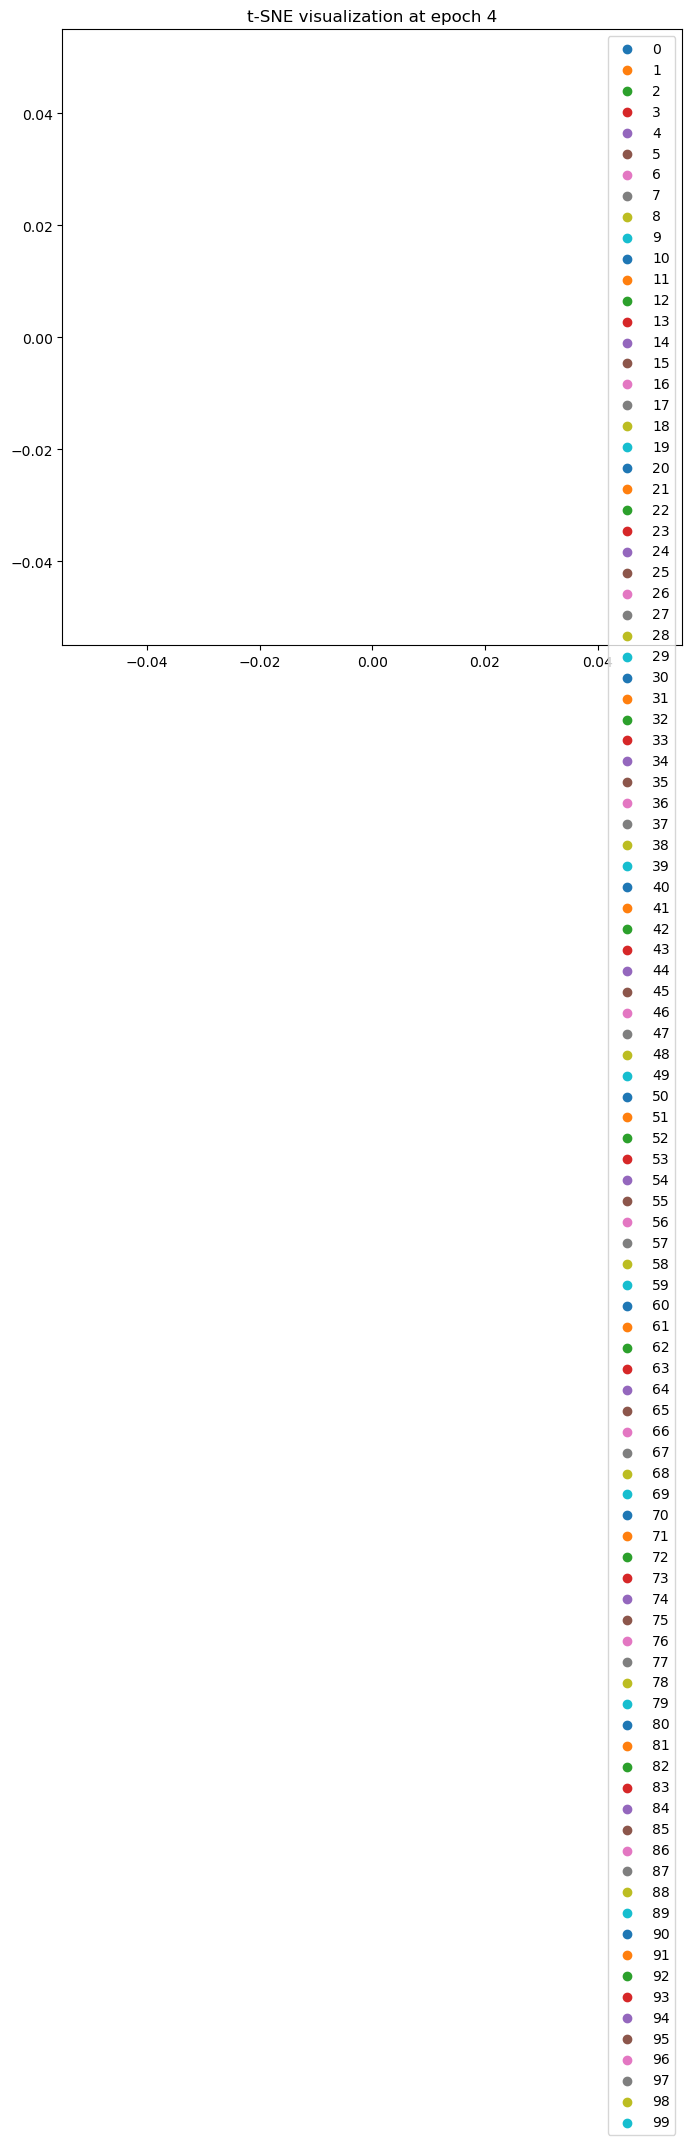

All Done!
--- 34.60485887527466 seconds ---


In [ ]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        optimizer.zero_grad()

        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        stats_batch_2 = torch.flatten(stats_batch, start_dim=0, end_dim=1)

        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)

        stats_vector = model(stats_batch_2)
        #loss definitions
        loss = loss_func_contrastive(stats_vector, texture_labels)
        
        loss.backward()
        optimizer.step()

        if(j==1000):
            break; 
        training_loss.append(loss.item())
        
    if(i%10==0):
        print('*',end='')
        print((f'Finished Epoch {i}. Loss at {loss}.'))
    num_total_epochs = num_total_epochs + 1

print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_OT_KTH.pth')

## Weight selection

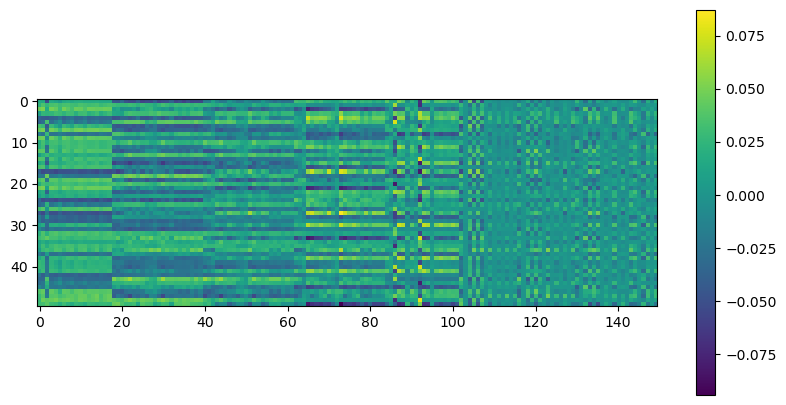

In [17]:
#Get the weights of the network
weights_layer1 = model.layer1.weight.data

# Converting the tensor to a NumPy array
compressor_mat = weights_layer1.cpu().numpy()

plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()


In [18]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?

stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

# Save the current seed's rankings
all_rankings_weight[seed] = list(stat_index_array)

# Persist the results
with open('feature_rankings_KTH_OT_weight.pkl', 'wb') as file:
    pickle.dump(all_rankings_weight, file)

## Shapley selection

In [19]:
import shap

model = model.eval().cpu()

def sim_func(mask):
    with torch.no_grad():

        mask = torch.tensor(mask).to(torch.float32)

        print(mask.shape)
        stats = stats_batch_2.reshape(batches, num_crops, num_stats).cpu()
        print(stats.shape)
        d, c2 = mask.shape
        assert num_stats == c2
        masked_stats = (torch.einsum("bnc,dc->bdnc", stats, mask)
                        .reshape(batches * d * num_crops, num_stats))

        embs = (model
                .forward(masked_stats)
                .reshape(batches, d, num_crops, -1))

        return (torch.einsum("bdnc,bdmc->bdnm", embs, embs)
                .mean(dim=[0, 2, 3])
                .unsqueeze(-1).numpy())

reference = np.zeros((1, num_stats))
input = np.ones((1, num_stats))
explainer = shap.KernelExplainer(
    sim_func,
    reference
)

shap_values = np.abs(explainer.shap_values(input)[0].squeeze())

torch.Size([1, 150])
torch.Size([100, 5, 150])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 150])
torch.Size([100, 5, 150])
torch.Size([2348, 150])
torch.Size([100, 5, 150])


In [20]:
# Sorting the indices based on the shap values
sorted_indices = np.argsort(shap_values)[::-1]

# Save the current seed's rankings
all_rankings_shapley[seed] = list(sorted_indices)

# Persist the results
with open('feature_rankings_KTH_OT_shapley.pkl', 'wb') as file:
    pickle.dump(all_rankings_shapley, file)


## Compute average feature rank
After running for several seeds, we now can compute the average ranks

### Compute for shapley

In [21]:
with open('feature_rankings_KTH_OT_shapley.pkl', 'rb') as file:
    loaded_rankings = pickle.load(file)

# Initialize a dictionary to store summed ranks for each feature
summed_ranks = {feature: 0 for feature in range(150)}

# Sum the ranks for each feature across seeds
for seed, rankings in loaded_rankings.items():
    for rank, feature in enumerate(rankings):
        summed_ranks[feature] += rank

# Compute the average rank for each feature
average_ranks = {feature: total_rank/len(loaded_rankings) for feature, total_rank in summed_ranks.items()}

# Sort the features based on their average ranks
sorted_avg_ranks = sorted(average_ranks.items(), key=lambda x: x[1])

# Print the sorted features along with their labels
for feature, avg_rank in sorted_avg_ranks:
    label = ostat_labels[feature]
    print(f"{label}: {avg_rank:.2f}")

# Save averaged ranks to a new pickle file
with open('averaged_feature_rankings_KTH_OT_shapley.pkl', 'wb') as file:
    pickle.dump(average_ranks, file)


edge_stop 2 2: 0.00
edge_stop 3 2: 1.00
edge_variance 3 3: 2.00
edge_correlation (2, 3) 3: 3.00
edge_correlation (3, 4) 3: 4.00
edge_correlation 3 (0, 2): 5.00
edge_correlation 3 (1, 3): 6.00
edge_correlation 3 (1, 2): 7.00
edge_mean 3 3: 8.00
edge_mean 3 1: 9.00
edge_stop 2 3: 10.00
edge_stop 3 0: 11.00
edge_mean 2 1: 12.00
edge_correlation 3 (2, 3): 13.00
edge_mean 4 3: 14.00
edge_variance 3 1: 15.00
edge_variance 1 1: 16.00
edge_stop 2 0: 17.00
edge_variance 3 2: 18.00
edge_correlation (2, 3) 1: 19.00
edge_correlation 3 (0, 3): 20.00
edge_correlation 4 (1, 3): 21.00
edge_correlation (3, 4) 1: 22.00
edge_correlation (1, 2) 3: 23.00
edge_mean 2 3: 24.00
edge_variance 4 3: 25.00
edge_stop 3 3: 26.00
edge_mean 4 1: 27.00
edge_stop 2 1: 28.00
edge_mean 3 2: 29.00
edge_variance 2 1: 30.00
edge_correlation 2 (1, 3): 31.00
edge_variance 4 1: 32.00
edge_correlation 2 (2, 3): 33.00
phase_correlation 3 er (2, 3): 34.00
edge_stop 1 2: 35.00
edge_correlation (1, 2) 2: 36.00
edge_variance 2 3: 37

### Compute for weight

In [22]:
with open('feature_rankings_KTH_OT_weight.pkl', 'rb') as file:
    loaded_rankings = pickle.load(file)

# Initialize a dictionary to store summed ranks for each feature
summed_ranks = {feature: 0 for feature in range(150)}

# Sum the ranks for each feature across seeds
for seed, rankings in loaded_rankings.items():
    for rank, feature in enumerate(rankings):
        summed_ranks[feature] += rank

# Compute the average rank for each feature
average_ranks_weight = {feature: total_rank/len(loaded_rankings) for feature, total_rank in summed_ranks.items()}

# Sort the features based on their average ranks
sorted_avg_ranks = sorted(average_ranks_weight.items(), key=lambda x: x[1])

# Print the sorted features along with their labels
for feature, avg_rank in sorted_avg_ranks:
    label = ostat_labels[feature]
    print(f"{label}: {avg_rank:.2f}")

# Save averaged ranks to a new pickle file
with open('averaged_feature_rankings_KTH_OT_weight.pkl', 'wb') as file:
    pickle.dump(average_ranks_weight, file)

edge_stop 4 2: 0.00
edge_stop 3 2: 1.00
edge_stop 4 0: 2.00
edge_stop 3 0: 3.00
variance: 4.00
skew 3: 5.00
kurtosis 4: 6.00
variance 1: 7.00
kurtosis 5: 8.00
edge_mean 3 1: 9.00
skew 2: 10.00
edge_mean 4 1: 11.00
variance 2: 12.00
edge_mean 3 3: 13.00
skew 4: 14.00
skew 1: 15.00
edge_mean 1 3: 16.00
edge_mean 1 1: 17.00
edge_mean 4 3: 18.00
variance 3: 19.00
skew 5: 20.00
kurtosis 3: 21.00
variance 4: 22.00
edge_correlation 1 (0, 2): 23.00
edge_correlation 1 (1, 3): 24.00
edge_correlation 3 (0, 2): 25.00
edge_stop 1 3: 26.00
edge_stop 1 1: 27.00
edge_variance 4 1: 28.00
edge_mean 1 0: 29.00
edge_correlation 1 (0, 3): 30.00
kurtosis 2: 31.00
variance 5: 32.00
edge_variance 1 1: 33.00
edge_correlation (3, 4) 3: 34.00
edge_mean 2 1: 35.00
edge_variance 3 3: 36.00
edge_stop 1 0: 37.00
edge_variance 1 0: 38.00
edge_correlation 1 (0, 1): 39.00
edge_variance 4 3: 40.00
edge_stop 2 2: 41.00
edge_stop 1 2: 42.00
edge_variance 1 3: 43.00
edge_correlation (3, 4) 1: 44.00
edge_variance 3 1: 45.00

## Obtain the various metrics for the analysis

In [23]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [25]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]
raw_stats = [0,1]

In [36]:
# Groups of indices
rawstats = [0,1]
bandpass_variance = [i for i, label in enumerate(ostat_labels) if 'bandpass_variance' in label]
low = [3, 4, 5]
nonoriented = list(range(6, 20))
edgemean = [i for i, label in enumerate(ostat_labels) if 'edge_mean' in label]
edgevariance = [i for i, label in enumerate(ostat_labels) if 'edge_variance' in label]
edgecorrelation = [i for i, label in enumerate(ostat_labels) if 'edge_correlation' in label]
phase = [i for i, label in enumerate(ostat_labels) if 'phase' in label]
stop = [i for i, label in enumerate(ostat_labels) if 'stop' in label]

### Get the indices for the 50 statistics
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]

heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))

# Compute mean ranks for each group and print
groups = {
    "RawStats": rawstats,
    "Bandpass Variance": bandpass_variance,
    "Low": low,
    "NonOriented": nonoriented,
    "Edge Mean": edgemean,
    "Edge Variance": edgevariance,
    "Edge Correlation": edgecorrelation,
    "Phase": phase,
    "Stop": stop
}

In [39]:
import pickle

with open('averaged_feature_rankings_KTH_OT_weight.pkl', 'rb') as file:
    average_ranks = pickle.load(file)


Calculate the various metrics

In [40]:
# First, sort the average_ranks to get the top ranked features
sorted_indices = sorted(range(len(average_ranks)), key=lambda k: average_ranks[k])

# 1. Count how many of the heegerbergen_indices are among the top 15 ranked features.
count_top_15 = sum([1 for idx in heegerbergen_indices if idx in sorted_indices[:15]])
print(f"{count_top_15} of the heegerbergen_indices are among the top 15 ranked features.")

# 2. Calculate the median rank of the heegerbergen_indices.
heegerbergen_ranks = [sorted_indices.index(idx) for idx in heegerbergen_indices]
median_rank = sorted(heegerbergen_ranks)[len(heegerbergen_ranks) // 2]
print(f"Median rank of heegerbergen_indices is: {median_rank + 1}")  # adding 1 to shift from 0-based index to 1-based rank

# 3. Calculate the mean rank of the heegerbergen_indices.
mean_rank = sum(heegerbergen_ranks) / len(heegerbergen_ranks)
print(f"Mean rank of heegerbergen_indices is: {mean_rank + 1}")  # adding 1 to shift from 0-based index to 1-based rank


11 of the heegerbergen_indices are among the top 15 ranked features.
Median rank of heegerbergen_indices is: 37
Mean rank of heegerbergen_indices is: 47.44


In [35]:
def compute_group_mean_rank(indices, average_ranks):
    group_ranks = [average_ranks[idx] for idx in indices]
    return sum(group_ranks) / len(group_ranks) if group_ranks else None

# Compute average rank for each group
group_avg_rank = {group_name: compute_group_mean_rank(indices, average_ranks) for group_name, indices in groups.items()}

# Print the results
for group_name, avg_rank in group_avg_rank.items():
    print(f"{group_name} average rank: {avg_rank:.2f}")

RawStats average rank: 28.50
Bandpass Variance average rank: 47.00
Low average rank: 30.67
NonOriented average rank: 19.07
Edge Mean average rank: 46.69
Edge Variance average rank: 73.69
Edge Correlation average rank: 69.72
Phase average rank: 115.77
Stop average rank: 49.12


## Same for shapley

In [41]:
import pickle

with open('averaged_feature_rankings_KTH_OT_shapley.pkl', 'rb') as file:
    average_ranks = pickle.load(file)


In [42]:
# First, sort the average_ranks to get the top ranked features
sorted_indices = sorted(range(len(average_ranks)), key=lambda k: average_ranks[k])

# 1. Count how many of the heegerbergen_indices are among the top 15 ranked features.
count_top_15 = sum([1 for idx in heegerbergen_indices if idx in sorted_indices[:15]])
print(f"{count_top_15} of the heegerbergen_indices are among the top 15 ranked features.")

# 2. Calculate the median rank of the heegerbergen_indices.
heegerbergen_ranks = [sorted_indices.index(idx) for idx in heegerbergen_indices]
median_rank = sorted(heegerbergen_ranks)[len(heegerbergen_ranks) // 2]
print(f"Median rank of heegerbergen_indices is: {median_rank + 1}")  # adding 1 to shift from 0-based index to 1-based rank

# 3. Calculate the mean rank of the heegerbergen_indices.
mean_rank = sum(heegerbergen_ranks) / len(heegerbergen_ranks)
print(f"Mean rank of heegerbergen_indices is: {mean_rank + 1}")  # adding 1 to shift from 0-based index to 1-based rank


5 of the heegerbergen_indices are among the top 15 ranked features.
Median rank of heegerbergen_indices is: 74
Mean rank of heegerbergen_indices is: 66.42


In [43]:
def compute_group_mean_rank(indices, average_ranks):
    group_ranks = [average_ranks[idx] for idx in indices]
    return sum(group_ranks) / len(group_ranks) if group_ranks else None

# Compute average rank for each group
group_avg_rank = {group_name: compute_group_mean_rank(indices, average_ranks) for group_name, indices in groups.items()}

# Print the results
for group_name, avg_rank in group_avg_rank.items():
    print(f"{group_name} average rank: {avg_rank:.2f}")

RawStats average rank: 109.50
Bandpass Variance average rank: 47.00
Low average rank: 107.00
NonOriented average rank: 83.79
Edge Mean average rank: 50.12
Edge Variance average rank: 54.88
Edge Correlation average rank: 48.75
Phase average rank: 109.33
Stop average rank: 56.31


## Weight selection

In [154]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]
raw_stats = [0,1]
heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))
#print(remaining_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  #@Mark: This should print 56

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:15] if index in heegerbergen_indices)

print(count)

37.5
11


In [155]:
# Compute the ranks
stat_index_list = list(stat_index_array)

ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Compute the mean rank
mean_rank = sum(ranks) / len(ranks) if ranks else None

print(mean_rank)  # This should print 4.0

47.6


In [28]:
def compute_mean_rank(indices, stat_index_list):
    ranks = [stat_index_list.index(idx) + 1 for idx in indices if idx in stat_index_list]
    return sum(ranks) / len(ranks) if ranks else None

# Groups of indices
rawstats = [0,1]
bandpass_variance = [i for i, label in enumerate(ostat_labels) if 'bandpass_variance' in label]
low = [3, 4, 5]
nonoriented = list(range(6, 20))
edgemean = [i for i, label in enumerate(ostat_labels) if 'edge_mean' in label]
edgevariance = [i for i, label in enumerate(ostat_labels) if 'edge_variance' in label]
edgecorrelation = [i for i, label in enumerate(ostat_labels) if 'edge_correlation' in label]
phase = [i for i, label in enumerate(ostat_labels) if 'phase' in label]
stop = [i for i, label in enumerate(ostat_labels) if 'stop' in label]


# Compute mean ranks for each group and print
groups = {
    "RawStats": rawstats,
    "Bandpass Variance": bandpass_variance,
    "Low": low,
    "NonOriented": nonoriented,
    "Edge Mean": edgemean,
    "Edge Variance": edgevariance,
    "Edge Correlation": edgecorrelation,
    "Phase": phase,
    "Stop": stop
}

for group_name, indices in groups.items():
    print(f"{group_name} mean rank:", compute_mean_rank(indices, stat_index_list))

NameError: name 'stat_index_list' is not defined

In [29]:
# Groups of indices
rawstats = [0,1]
bandpass_variance = [i for i, label in enumerate(ostat_labels) if 'bandpass_variance' in label]
low = [3, 4, 5]
nonoriented = list(range(6, 20))
edgemean = [i for i, label in enumerate(ostat_labels) if 'edge_mean' in label]
edgevariance = [i for i, label in enumerate(ostat_labels) if 'edge_variance' in label]
edgecorrelation = [i for i, label in enumerate(ostat_labels) if 'edge_correlation' in label]
phase = [i for i, label in enumerate(ostat_labels) if 'phase' in label]
stop = [i for i, label in enumerate(ostat_labels) if 'stop' in label]


# Compute mean ranks for each group and print
groups = {
    "RawStats": rawstats,
    "Bandpass Variance": bandpass_variance,
    "Low": low,
    "NonOriented": nonoriented,
    "Edge Mean": edgemean,
    "Edge Variance": edgevariance,
    "Edge Correlation": edgecorrelation,
    "Phase": phase,
    "Stop": stop
}